# Stream Data Algorithms to count the number of unique users

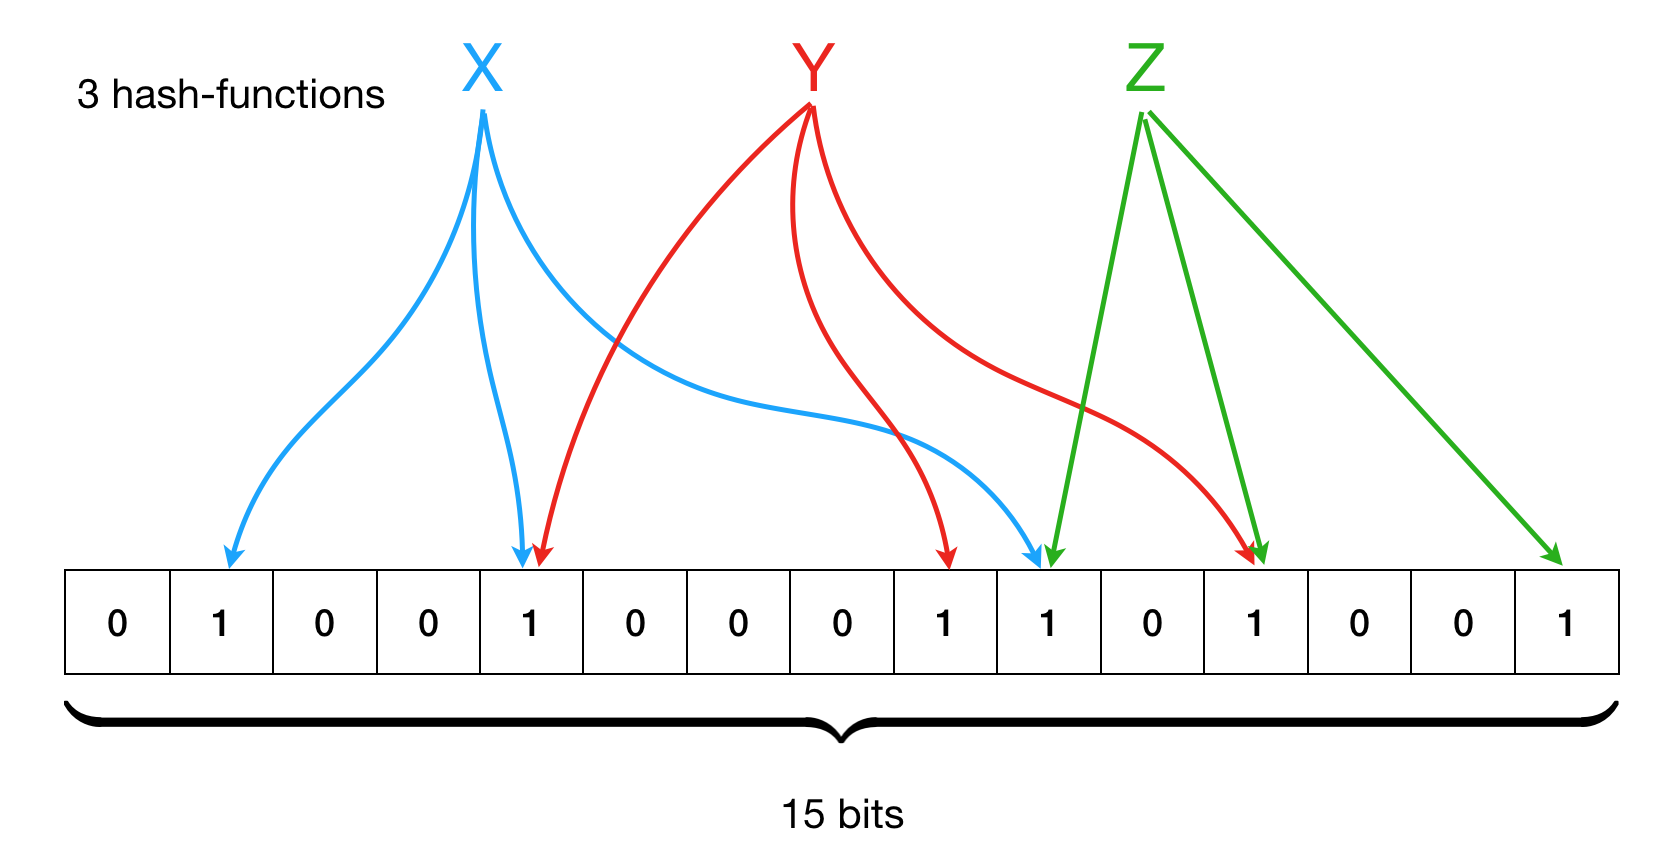

Unlike static data that is already stored, different approaches become necessary when handling data streams. <br>
Here, I will discuss three different approaches that utilizies available stream data algorithms, as well as Pyspark.

In [1]:
import findspark
findspark.init()

In [2]:
import time
import sys
import random
import binascii
import math

In [3]:
from blackbox import BlackBox

The BlackBox function imitates a streaming data, and we can adjust the stream size and number of asks. <br>
In this exercise, the stream size is 100, and number of ask will be 30.

## Bloom Filter
#### Explanation
Bloom filter is an excellent way to handle streams of data. <br>
Yes, it does allow some margin for error, but fortunately, the error won't be false negative. <br>
Meaning, if bloom filter says no, the answer will be no, and if bloom filter says yes, it may not be true. 

#### Mechanism
We will need an array A of n bits, initially all 0s. -> [0,0,0,0,0,0,0,0,0,0,0,0,0,....] <br>
For our case, we have set the value A as 69997. <br>
We also need hash functions that will turn the input into a pattern in the array.

In [4]:
input_file_path = 'users.txt'
stream_size = 100
num_of_asks = 30

### Data 
Our data is long list of user id with a length of 1518169.

In [5]:
with open('users.txt') as f:
    lines = f.readlines()

In [6]:
lines[0:10]

['lzlZwIpuSWXEnNS91wxjHw\n',
 'XvLBr-9smbI0m_a7dXtB7w\n',
 'QPT4Ud4H5sJVr68yXhoWFw\n',
 'i5YitlHZpf0B3R0s_8NVuw\n',
 's4FoIXE_LSGviTHBe8dmcg\n',
 'ZcsZdHLiJGVvDHVjeTYYnQ\n',
 'h3p6aeVL7vrafSOM50SsCg\n',
 'EbJMotYYkq-iq-v1u8wCYA\n',
 'nnB0AE1Cxp_0154xkhXelw\n',
 'XoEnrhtJc2pcdlQ09d8Oug\n']

In [7]:
len(lines)

1518169

#### def hash_func_generator(stream_size, num_of_asks):
For the optimal # of hash functions, we will use an equation: k = n/m ln(2). <br>
- k: # of hash functions
- n: bits in array 
- m: # of objects <br><br>
For the hash function, we will use the formula: f(x)= (ax + b) % m.

In [18]:
def hash_func_generator(stream_size, num_of_asks):
    n = int((69997 * math.log(2))/(stream_size*num_of_asks))
    random.seed(1)
    hash_function_list = []
    for i in range(0,n,1):
        if i == 0:
            a = random.sample(range(1, 100000), 1)[0]
            b = random.sample(range(1, 100000), 1)[0]
            hash_function_list.append([a,b])
        else:
            out = 0
            while out == 0:
                a = random.sample(range(1, 100000), 1)[0]
                b = random.sample(range(1, 100000), 1)[0]
                count = 0
                for j in hash_function_list:
                    temp_a = [a,j[0]]
                    temp_a.sort()
                    temp_b = [b,j[1]]
                    temp_b.sort()
                    if temp_a[1] % temp_a[0] != 0 and temp_b[1] % temp_b[0] != 0:
                        count +=1
                if count == len(hash_function_list):
                    hash_function_list.append([a,b])
                    out = 1

    return hash_function_list

In [19]:
def myhashs(s,stream_size,num_of_asks):
    hash_function_list = hash_func_generator(stream_size,num_of_asks)
    result = []
    for f in hash_function_list:
        temp = (f[0] * s + f[1]) % 69997
        result.append(temp)
    
    return result

#### bloom_filter(input_file_path, num_of_asks,stream_size):
The function performs few purposes:
- It encodes the user id to apply hash functions.
- By using the hashed values, the function modifies our bit-array.
- Using the bit-array, the function determines whether the user is unique or not. 
- Lastly, the function keeps track whether the decision is correct or not by tracking false positive and true negative.

In [20]:
def bloom_filter(input_file_path, num_of_asks,stream_size):
    bx = BlackBox()
    bit_array = [0] * 69997
    prev_user = set()
    fpr_list = []
    n = int((69997 * math.log(2))/(stream_size*num_of_asks))
    
    for i in range(0,num_of_asks,1):
        fp_count = 0
        tn_count = 0
        stream_users = bx.ask(input_file_path, stream_size)
        for j in stream_users:
            j = int(binascii.hexlify(j.encode('utf8')),16)
            prev_user.add(j)
            hashed = myhashs(j,stream_size,num_of_asks)
            count = 0
            for k in hashed:
                if bit_array[k] == 0:
                    bit_array[k] = 1
                else:
                    count+=1
            if count == n and j not in prev_user:
                fp_count+=1
            elif count != n and j not in prev_user:
                tn_count+=1
        if fp_count == 0 and tn_count == 0:
            fpr_list.append(0)
        else:
            fpr_list.append(fp_count/fp_count+tn_count)
    
    return fpr_list

In [21]:
answer = bloom_filter(input_file_path, num_of_asks,stream_size)

## Flajolet-Martin algorithm
Uses trailing zero to approximate the number of distinct elements in a stream

In [24]:
stream_size = 300
num_of_asks = 30

In [25]:
def hash_func_generator_flatjolet():
    random.seed(553)
    hash_function_list = []
    a = random.sample(range(1, 100000), 1)[0]
    b = random.sample(range(1, 100000), 1)[0]
    hash_function_list.append([a,b])
    
    return hash_function_list

In [26]:
def myhashs_flatjolet(s):
    hash_function_list = hash_func_generator_flatjolet()
    result = []
    for f in hash_function_list:
        temp = (f[0] * s + f[1]) % 8
        result.append(temp)
    
    return result

In [29]:
def flajolet_martin(input_file_path,stream_size,num_of_asks):
    bx = BlackBox()    
    trailing_list = []
    for i in range(0,num_of_asks,1):
        max_zero = 0
        stream_users = bx.ask(input_file_path, stream_size)
        for j in stream_users:
            j = int(binascii.hexlify(j.encode('utf8')),16)
            hashed = myhashs_flatjolet(j)[0]
            trailing = 8 - hashed
            if trailing > max_zero:
                max_zero = trailing
                
        trailing_list.append(2**max_zero)
        
    return trailing_list

In [30]:
final_list = flajolet_martin(input_file_path,stream_size,num_of_asks)

In [31]:
final_list

[64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64]